![](../src/image/meli5.JPG)

# Generador Embeddings Text-Embedding-3-Small

#### En este punto usare  el text-embedding-3-small para la generacion de los embeddings.

### Pasos
1. [Preparacion de la data.](#1)
1. [Preprocesamiento de los datos.](#2)
1. [Generacion de Embedding](#3)
1. [Extraccion de Embedding](#4)



<a id="1"></a> <br>
## 1.Preparacion de la data

#### El dataset usado es el proporcionado en el ejercicio ya con las etiquetas obtenidas en la clusterizacion. El dataset posee 185250 registros los cuales 117094 poseen etiquetas. Esta data mantiene la informacion de sellers de un e-commerce. de los cuales tomaremos 50 registros de cada cluster, 10 de los que no tienen etiqueta para la prediccion.

#### Combinaran las variables, y con el modelo se codificara las variables combinadas y dara resultado un vector embedding

In [14]:
import pandas as pd
import tiktoken
import matplotlib.pyplot as plt
import numpy as np

from utils.embeddings_utils import get_embedding

In [15]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  

In [16]:
path = 'data/data_embedding copy.csv'
df = pd.read_csv(path)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32529 entries, 0 to 32528
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         32529 non-null  int64  
 1   tim_day            32529 non-null  object 
 2   seller_nickname    32529 non-null  object 
 3   titulo             32529 non-null  object 
 4   seller_reputation  32529 non-null  object 
 5   stock              32529 non-null  int64  
 6   logistic_type      32529 non-null  object 
 7   condition          32529 non-null  object 
 8   is_refurbished     32529 non-null  bool   
 9   price              32529 non-null  float64
 10  regular_price      32529 non-null  float64
 11  categoria          32529 non-null  object 
 12  url                32529 non-null  object 
 13  category_id        32529 non-null  object 
 14  category_name      32529 non-null  object 
 15  Kmeans             32529 non-null  float64
 16  AgC                325

In [18]:
siglas = ['XD', 'FBM', 'DS', 'FLEX', 'Otro']
logistic_type = ['Cross Docking', 'FulfilledbyMerchant', 'DropShipping', 'FLEX', 'Otro']

df_lgt = pd.DataFrame(data={'Siglas_lt':siglas,"Lt":logistic_type})
df=pd.merge(left=df, right=df_lgt, how='left', left_on='logistic_type',right_on='Siglas_lt')
df.head(2)

,Unnamed: 0,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name,Kmeans,AgC,Siglas_lt,Lt
0,8,2024-08-01,92a7303a20,Gama De 12 Geles Semipermanente Esmalte Obp - ...,green_platinum,3020,FBM,new,False,198.34,211.0,MANICURE & PEDICURE,https://articulo.mercadolibre.com.mx/MLM-13745...,MANICURE & PEDICURE,MANICURA Y PEDICURA,0.0,0.0,FBM,FulfilledbyMerchant
1,15,2024-08-01,187ad66fb4,"Extensiones Pestañas Diy, Kit De Racimos De Pe...",green_platinum,557,FBM,new,False,255.60,360.0,BEAUTY PROFESSIONAL,https://articulo.mercadolibre.com.mx/MLM-19888...,BEAUTY PROFESSIONAL,BELLEZA PROFESIONAL,0.0,0.0,FBM,FulfilledbyMerchant


In [19]:
df.columns

Index(['Unnamed: 0', 'tim_day', 'seller_nickname', 'titulo',
       'seller_reputation', 'stock', 'logistic_type', 'condition',
       'is_refurbished', 'price', 'regular_price', 'categoria', 'url',
       'category_id', 'category_name', 'Kmeans', 'AgC', 'Siglas_lt', 'Lt'],
      dtype='object')

In [20]:
df['stock']=df['stock'].astype(str)
df['price']=df['price'].astype(str)
df['stock']=df['stock'].astype(str)
df['is_refurbished']=df['is_refurbished'].astype(int)
df['is_refurbished']=df['is_refurbished'].astype(str)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [21]:
df=df[df['seller_reputation'].isnull()==False]
df.shape

(32529, 18)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32529 entries, 0 to 32528
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tim_day            32529 non-null  object 
 1   seller_nickname    32529 non-null  object 
 2   titulo             32529 non-null  object 
 3   seller_reputation  32529 non-null  object 
 4   stock              32529 non-null  object 
 5   logistic_type      32529 non-null  object 
 6   condition          32529 non-null  object 
 7   is_refurbished     32529 non-null  object 
 8   price              32529 non-null  object 
 9   regular_price      32529 non-null  float64
 10  categoria          32529 non-null  object 
 11  url                32529 non-null  object 
 12  category_id        32529 non-null  object 
 13  category_name      32529 non-null  object 
 14  Kmeans             32529 non-null  float64
 15  AgC                32529 non-null  float64
 16  Siglas_lt          325

In [23]:
df['mix'] = "Stock: " + df['stock'].str.strip() + "; Refurbished: " + df['is_refurbished'].str.strip() + "; Logistic: " + df['Lt'].str.strip()+ "; Condition: " + df.condition.str.strip() + "; Price: " + df.price.str.strip() + "; Categoria " + df['category_id'].str.strip()
print(df.shape)


df.head(2)

(32529, 19)


,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name,Kmeans,AgC,Siglas_lt,Lt,mix
0,2024-08-01,92a7303a20,Gama De 12 Geles Semipermanente Esmalte Obp - ...,green_platinum,3020,FBM,new,0,198.34,211.0,MANICURE & PEDICURE,https://articulo.mercadolibre.com.mx/MLM-13745...,MANICURE & PEDICURE,MANICURA Y PEDICURA,0.0,0.0,FBM,FulfilledbyMerchant,Stock: 3020; Refurbished: 0; Logistic: Fulfill...
1,2024-08-01,187ad66fb4,"Extensiones Pestañas Diy, Kit De Racimos De Pe...",green_platinum,557,FBM,new,0,255.6,360.0,BEAUTY PROFESSIONAL,https://articulo.mercadolibre.com.mx/MLM-19888...,BEAUTY PROFESSIONAL,BELLEZA PROFESIONAL,0.0,0.0,FBM,FulfilledbyMerchant,Stock: 557; Refurbished: 0; Logistic: Fulfille...


#### Como mencione anteriormente seleccionaremos 50 de cada cluster para tener una data de 210 registros, donde 10 son de validacion.

In [24]:
df.columns

Index(['tim_day', 'seller_nickname', 'titulo', 'seller_reputation', 'stock',
       'logistic_type', 'condition', 'is_refurbished', 'price',
       'regular_price', 'categoria', 'url', 'category_id', 'category_name',
       'Kmeans', 'AgC', 'Siglas_lt', 'Lt', 'mix'],
      dtype='object')

In [25]:
col = ['tim_day', 'seller_nickname', 'titulo', 'seller_reputation', 'stock',
       'logistic_type', 'condition', 'is_refurbished', 'price',
       'regular_price', 'categoria', 'url', 'category_id', 'category_name',
        'Kmeans', 'AgC', 'Siglas_lt', 'Lt', 'mix']
cntxcluster = 50
clusters=4
dfy=pd.DataFrame()
for i in range(0,clusters): # Sacamos los 50 registros de cada cluster.
    print(f"Cluster {i}")
    reviews = df[df.Kmeans == i].sample(cntxcluster, random_state=42).values
    dfx = pd.DataFrame(data=reviews,columns=col)
    dfy = pd.concat([dfy,dfx], axis=0)



print(dfy.shape)
print(dfy.Kmeans.value_counts())
dfy = pd.concat([dfy,df[df['Kmeans'].isnull()][:10]], axis=0) # concatenamos con los
print(dfy.shape)
dfy = dfy.iloc[np.random.permutation(len(dfy))].reset_index(drop=True)
dfy.head(2)

Cluster 0
Cluster 1
Cluster 2
Cluster 3
(200, 19)
Kmeans
0.0    50
1.0    50
2.0    50
3.0    50
Name: count, dtype: int64
(200, 19)


,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name,Kmeans,AgC,Siglas_lt,Lt,mix
0,2024-08-01,89a50330de,30 Piezas En Forma De T Botella De Vino Corcho...,green_silver,46,DS,new,0,265.06,278.91,HOUSEHOLD ITEMS,https://articulo.mercadolibre.com.mx/MLM-20363...,HOUSEHOLD ITEMS,ARTÍCULOS DEL HOGAR,2.0,1.0,DS,DropShipping,Stock: 46; Refurbished: 0; Logistic: DropShipp...
1,2024-08-01,7da042e7e6,Pala Recolectora De Heces Popo De Mascotas 28cm,green_platinum,108,FBM,new,0,66.75,89.0,PET,https://articulo.mercadolibre.com.mx/MLM-19567...,PET,MASCOTAS,2.0,2.0,FBM,FulfilledbyMerchant,Stock: 108; Refurbished: 0; Logistic: Fulfille...


<a id="2"></a> <br>
# 2. Preprocesamiento de Datos

#### Ya con la data seleccionada ahora lo que realizaremos sera la tokenizacion  con tiktoken utilizando el encoding de 3-small definido al inicio.

In [26]:
encoding = tiktoken.get_encoding(embedding_encoding)

#Dado que utilizar la API de OpenAI no es gratis, debemos tartar de controlar los token
#que vamos a gastar con el fin de no gastar creditos innecesarios. por esa razon no tomamos la variable titulo
#ya que es demasiada grande esus strings.
# tambien es importante revisar que tanto es la maxima cantidad de token ya que se el
# 3-small tienen un limite de 8000 tokens por entrada o por registro.
dfy['tokens'] = dfy.mix.apply(lambda x: len(encoding.encode(x)))


6907


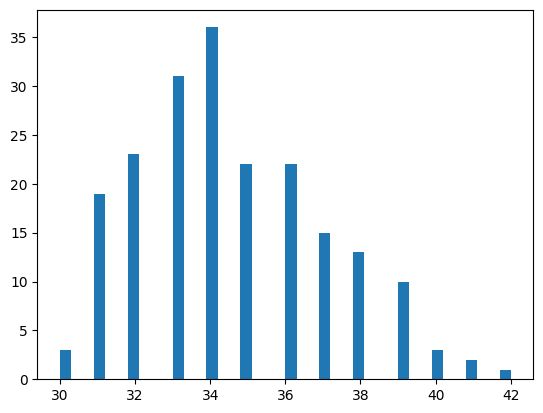

In [27]:
print(sum(dfy.tokens.values))
plt.hist(dfy.tokens, bins= 40);


<a id="3"></a> <br>
# 3. Generacion de Embedding

##### para esta primera prueba utilizaremos de input 85977 tokens de entrada y de respuesta seran 250.

In [28]:
# antes de correr cualquier modelo de la api de openai debemos asegurarnos que esta ya esta,
#completamente configurada en el ambiente.

#ahora
dfy["embedding"] = dfy.mix.apply(lambda x: get_embedding(x, model=embedding_model))



In [30]:
dfy.head(5)

,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,...,url,category_id,category_name,Kmeans,AgC,Siglas_lt,Lt,mix,tokens,embedding
0,2024-08-01,89a50330de,30 Piezas En Forma De T Botella De Vino Corcho...,green_silver,46,DS,new,0,265.06,278.91,...,https://articulo.mercadolibre.com.mx/MLM-20363...,HOUSEHOLD ITEMS,ARTÍCULOS DEL HOGAR,2.0,1.0,DS,DropShipping,Stock: 46; Refurbished: 0; Logistic: DropShipp...,33,"[0.0070685939863324165, 0.035163041204214096, ..."
1,2024-08-01,7da042e7e6,Pala Recolectora De Heces Popo De Mascotas 28cm,green_platinum,108,FBM,new,0,66.75,89.0,...,https://articulo.mercadolibre.com.mx/MLM-19567...,PET,MASCOTAS,2.0,2.0,FBM,FulfilledbyMerchant,Stock: 108; Refurbished: 0; Logistic: Fulfille...,32,"[-0.02699536643922329, 0.028292439877986908, -..."
2,2024-08-01,91329752da,Un Par De Herramientas De Soporte Para Los Oíd...,green_silver,100,DS,new,0,261.7,308.09,...,https://articulo.mercadolibre.com.mx/MLM-31927...,PET,MASCOTAS,2.0,1.0,DS,DropShipping,Stock: 100; Refurbished: 0; Logistic: DropShip...,30,"[-0.01750161498785019, 0.02213890291750431, -0..."
3,2024-08-01,e49a9f303b,Suero Verde Hidratante Ere Perez Tipo De Piel ...,green_silver,2,FBM,new,0,738.0,820.0,...,https://articulo.mercadolibre.com.mx/MLM-19101...,BEAUTY PERSONAL CARE,CUIDADO PERSONAL Y BELLEZA,3.0,0.0,FBM,FulfilledbyMerchant,Stock: 2; Refurbished: 0; Logistic: Fulfilledb...,37,"[-0.020844023674726486, 0.025340864434838295, ..."
4,2024-08-01,d56f8825ad,Inyector Gasolina Sentra Tsuru 1997 2000 2001 ...,green_platinum,5,FBM,new,0,674.1,749.0,...,https://articulo.mercadolibre.com.mx/MLM-17967...,ACC CARS & VANS,ACCESORIOS PARA AUTOS Y CAMIONETAS,1.0,3.0,FBM,FulfilledbyMerchant,Stock: 5; Refurbished: 0; Logistic: Fulfilledb...,37,"[-0.04704395309090614, 0.028241679072380066, -..."


In [31]:
#ahora vemos nuestras lista los embedding desde 3-small de la muestra de nuestros datos.
print(dfy['embedding'].shape)
dfy['embedding']

(200,)


0      [0.0070685939863324165, 0.035163041204214096, ...
1      [-0.02699536643922329, 0.028292439877986908, -...
2      [-0.01750161498785019, 0.02213890291750431, -0...
3      [-0.020844023674726486, 0.025340864434838295, ...
4      [-0.04704395309090614, 0.028241679072380066, -...
                             ...                        
195    [-0.036176372319459915, 0.048606064170598984, ...
196    [-0.023767990991473198, 0.03342093899846077, -...
197    [-0.04059247672557831, 0.022805044427514076, -...
198    [-0.0067464630119502544, 0.00943252444267273, ...
199    [0.0032425422687083483, 0.03199721872806549, -...
Name: embedding, Length: 200, dtype: object

<a id="4"></a> <br>
# 4. Exportacion del Embedding

In [ ]:
dfy.to_csv("data/data_embedding_270.csv")
